In [1]:
import ifcopenshell as ifc
import pandas as pd

from digital_hospitals.bim import models

## Read the model

In [2]:
model = models.BimModel.from_ifc('../secrets/histo.ifc')

In [3]:
# Test BimData serialisation/deserialisation

model_data = models.BimData.from_obj(model)

with open('model.out.json', 'w') as file:
    print(model_data.model_dump_json(), file=file)

model_data = models.BimData.model_validate_json(open('model.out.json').read())
model = model_data.to_obj()

**Number and doors and walls per floor:**

In [4]:
model.doors.groupby(['floor']).door_name.count()

floor
Level 1 Basement        46
Level 2 Ground floor    95
Level 3 First floor     98
Level 4 Second floor    68
Level 5 Third floor     73
Level 6 Fourth floor    66
Name: door_name, dtype: int64

In [5]:
model.walls.groupby(['floor']).wall_name.count()

floor
Level 1 Basement        183
Level 2 Ground floor    257
Level 3 First floor     242
Level 4 Second floor    202
Level 5 Third floor     208
Level 6 Fourth floor    205
Name: wall_name, dtype: int64

**Door list:**

In [6]:
door_list = model.doors.loc[
    model.doors.door_name.str.fullmatch(r'd\d+')
].door_name.to_list()

model.doors.loc[model.doors.door_name.isin(door_list)]

,door_name,floor,x0,x1,y0,y1,z0
430,d1,Level 4 Second floor,62.027627,63.007627,60.642963,60.820963,10.5
431,d2,Level 4 Second floor,67.062127,67.942127,58.859361,59.037361,10.5
432,d3,Level 4 Second floor,69.609627,71.169627,60.588963,60.787963,10.5
433,d4,Level 4 Second floor,70.722127,71.602127,58.859361,59.037361,10.5
434,d5,Level 4 Second floor,78.321879,79.881879,60.694861,60.893861,10.5
435,d6,Level 4 Second floor,78.062173,79.622173,58.750861,58.949861,10.5
436,d7,Level 4 Second floor,53.848127,54.047127,59.113611,60.673611,10.5
437,d8,Level 4 Second floor,45.713127,45.912127,59.062361,60.622361,10.5
438,d9,Level 4 Second floor,48.957877,50.517877,60.644861,60.843861,10.5
439,d10,Level 4 Second floor,55.754627,57.314627,58.848361,59.047361,10.5


## Plot the floor plan

In [7]:
import numpy as np
import networkx as ntx
import shapely as shp
from shapely.plotting import plot_polygon

def box_type(
        model: models.ShapelyModel,
        box: shp.Polygon) -> str:
    shp.prepare(box)
    if any(box.intersects(list(model.door_shapes.values()))):
        # Intersects with door in ok_doors
        return 'door'
    if any(box.intersects(model.wall_shapes)):
        # Intersects with wall
        return 'wall'
    return 'empty'

def grid_plot(model, ax, title,
              bottom_left,
              top_right,
              grid_size = 0.5,):
    x_min, y_min = bottom_left
    x_max, y_max = top_right
    n_x = len(np.arange(x_min, x_max, grid_size))
    n_y = len(np.arange(y_min, y_max, grid_size))

    # Create base grid, assigning 'box' and 'pos' attributes
    # to each node
    grid = ntx.grid_2d_graph(n_x, n_y)
    for n in grid.nodes:
        i, j = n
        x0 = x_min + i*grid_size
        y0 = y_min + j*grid_size
        grid.nodes[n]['box'] = shp.box(
            x0, y0, x0+grid_size, y0+grid_size, ccw=False
        )
        shp.prepare(grid.nodes[n]['box'])
        centroid = grid.nodes[n]['box'].centroid
        grid.nodes[n]['pos'] = (centroid.x, centroid.y)

    for n, v in grid.nodes(data=True):
        grid.nodes[n]['type'] = t = box_type(model, v['box'])
        grid.nodes[n]['color'] = 'gray' if t == 'wall' else 'red' if t == 'door' else 'white'
    
    for n, v in grid.nodes(data=True):
        plot_polygon(
            v['box'], ax, facecolor=v['color'], add_points=False, linewidth=0.3,
            edgecolor=('#aaa' if v['type'] == 'empty' else "black")
        )
    
    for n, p in model.door_shapes.items():
        ax.text(p.centroid.x+0.2, p.centroid.y+0.2, n, color='#204')

    ax.axis('square')
    x0, y0 = bottom_left
    x1, y1 = top_right
    ax.set_xlim((x0, x1))
    ax.set_ylim((y0, y1))
    ax.set_title(title)

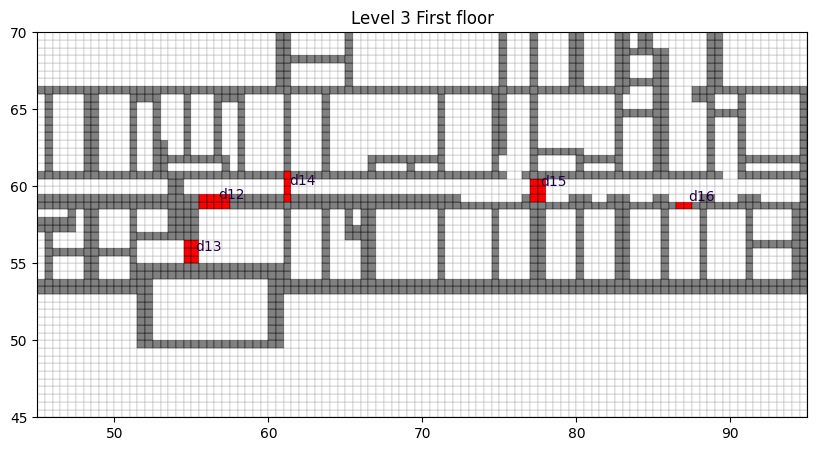

In [8]:
import matplotlib.pyplot as plt

l3_model = models.ShapelyModel(model, 'Level 3 First floor', door_list)

fig, ax = plt.subplots(figsize=(10,5))
grid_plot(l3_model, ax, 'Level 3 First floor', bottom_left=(45,45), top_right=(95,70))

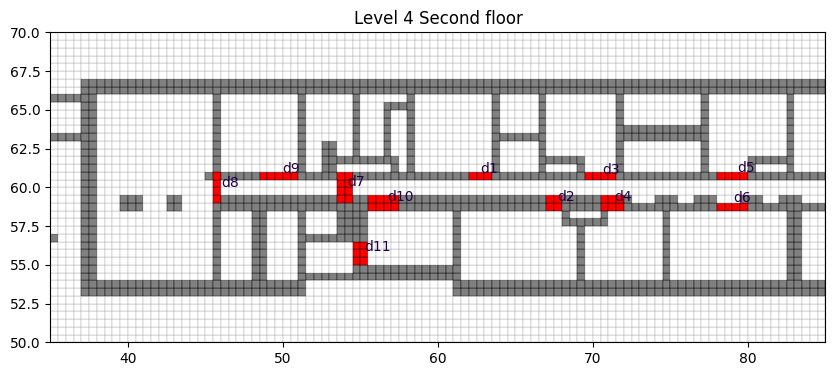

In [9]:
l4_model = models.ShapelyModel(model, 'Level 4 Second floor', door_list)

fig, ax = plt.subplots(figsize=(10,5))
grid_plot(l4_model, ax, 'Level 4 Second floor', bottom_left=(35,50), top_right=(85,70))

## Compute runner times

In [10]:
extra_paths = [
    models.Path(path=['d10', 'd12'], duration_seconds=120., required_assets=['Lift']),
    models.Path(path=['d11', 'd13'], duration_seconds=45., required_assets=['Lift'])
]

In [11]:
g = models.logical_graph(
    model,
    door_list,
    extra_paths,
    models.DEFAULT_RUNNER_SPEED
)

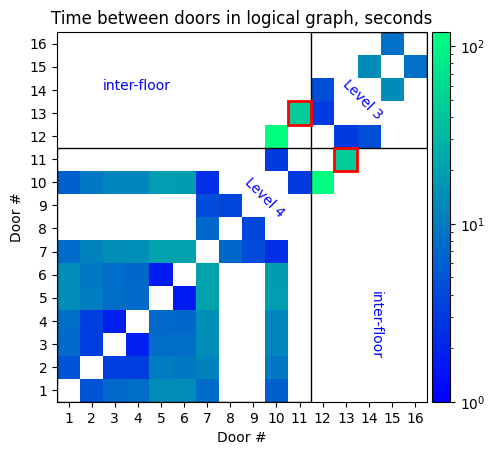

In [13]:
mat = ntx.adjacency_matrix(g).todense()

from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(mat, interpolation="nearest", origin="lower",
           cmap='winter', norm=LogNorm(vmin=1, vmax=120))
ax.add_patch(Rectangle((-0.5,-0.5), 11, 11, fill=False, edgecolor='k'))
ax.add_patch(Rectangle((10.5,10.5), 5, 5, fill=False, edgecolor='k'))

# Highlight lifts
ax.add_patch(Rectangle((9.5,11.5), 1, 1, fill=False, edgecolor='r', linewidth=2))
ax.add_patch(Rectangle((11.5,9.5), 1, 1, fill=False, edgecolor='r', linewidth=2))

ax.text(1.5,13,'inter-floor', color='b')
ax.text(7.5,7.5,'Level 4', color='b', rotation=-45)
ax.text(13,1.5,'inter-floor', rotation=-90, color='b')
ax.text(11.75,11.75,'Level 3', color='b', rotation=-45)
fig.colorbar(im, cax=cax, orientation='vertical')

ax.set_xlabel('Door #')
ax.set_ylabel('Door #')
ax.set_title('Time between doors in logical graph, seconds')
ax.set_xticks(range(16), range(1,17))
ax.set_yticks(range(16), range(1,17))

In [14]:
data = ntx.node_link_data(g)
data

{'directed': False,
 'multigraph': False,
 'graph': {},
 'nodes': [{'id': 'd1'},
  {'id': 'd2'},
  {'id': 'd3'},
  {'id': 'd4'},
  {'id': 'd5'},
  {'id': 'd6'},
  {'id': 'd7'},
  {'id': 'd8'},
  {'id': 'd9'},
  {'id': 'd10'},
  {'id': 'd11'},
  {'id': 'd12'},
  {'id': 'd13'},
  {'id': 'd14'},
  {'id': 'd15'},
  {'id': 'd16'}],
 'links': [{'weight': 4.8570226039551585, 'source': 'd1', 'target': 'd2'},
  {'weight': 7.3570226039551585, 'source': 'd1', 'target': 'd3'},
  {'weight': 7.7736892706218255, 'source': 'd1', 'target': 'd4'},
  {'weight': 14.44035593728849, 'source': 'd1', 'target': 'd5'},
  {'weight': 14.44035593728849, 'source': 'd1', 'target': 'd6'},
  {'weight': 7.6725889843221236, 'source': 'd1', 'target': 'd7'},
  {'weight': 5.934433619633036, 'source': 'd1', 'target': 'd10'},
  {'weight': 3.1903559372884915, 'source': 'd2', 'target': 'd3'},
  {'weight': 3.2618446353109127, 'source': 'd2', 'target': 'd4'},
  {'weight': 10.273689270621826, 'source': 'd2', 'target': 'd5'},
  {'

In [15]:
# Check deserialisation
g2 = ntx.node_link_graph(data)
g.nodes == g2.nodes and g.edges == g2.edges

True